In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

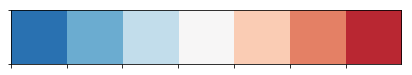

In [4]:
import seaborn as sns
sns.palplot(sns.color_palette("RdBu_r", 7))

sns.set_style("whitegrid")

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [5]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


<p>Base com todas chuvas EXTREMAS com inicio e fim de cada chuva extrema (> 50mm em 24 horas)</p>

In [6]:
dfhr = pd.read_csv('../data/extreme_prcp_evolution.csv')
print len(dfhr)

31710


<p>Subconjunto da base principal considerando o inicio e fim das chuvas extremas (> 50mm em 24 horas)</p>

In [8]:
dfext = pd.read_csv('../data/sudeste_extreme_prcp.csv', index_col=0)
print len(dfext)

101976


# Pré-processamento

In [9]:
dfhr['pstr'] = pd.to_datetime(dfhr['pstr'])
dfhr['pend'] = pd.to_datetime(dfhr['pend'])

In [10]:
dfhr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31710 entries, 0 to 31709
Data columns (total 29 columns):
id      31710 non-null int64
wsid    31710 non-null int64
pstr    31710 non-null datetime64[ns]
pend    31710 non-null datetime64[ns]
psum    31710 non-null float64
1       31710 non-null float64
2       31710 non-null float64
3       31710 non-null float64
4       31710 non-null float64
5       31710 non-null float64
6       31710 non-null float64
7       31710 non-null float64
8       31710 non-null float64
9       31710 non-null float64
10      31710 non-null float64
11      31710 non-null float64
12      31710 non-null float64
13      31710 non-null float64
14      31710 non-null float64
15      31710 non-null float64
16      31710 non-null float64
17      31710 non-null float64
18      31710 non-null float64
19      31710 non-null float64
20      31710 non-null float64
21      31710 non-null float64
22      31710 non-null float64
23      31710 non-null float64
24      31710

In [11]:
df['mdct'] = pd.to_datetime(df['mdct'])
df['date'] = pd.to_datetime(df['date'])

strfld = ['wsnm','inme','city','prov']

for f in strfld:
    df[f] = df[f].astype(str)    

In [12]:
# Campos não numericos e campos derivados
DES= ['wsid','wsnm','elvt','lat','lon','inme','city','prov']
INT = ['yr','mo','da','hr']
DAT = ['mdct','date']
DER = ['smax','smin','tmax','tmin','dmax','dmin','hmax','hmin']

In [13]:
# dataframe apenas com os dados continuos
dfcont = df
for f in DES + INT + DAT:    
    dfcont = dfcont.drop(f, 1)

In [14]:
dfcont.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9779168 entries, 0 to 9779167
Data columns (total 17 columns):
prcp    float64
stp     float64
smax    float64
smin    float64
gbrd    float64
temp    float64
tmax    float64
tmin    float64
dewp    float64
dmax    float64
dmin    float64
hmdy    float64
hmax    float64
hmin    float64
wdsp    float64
wdct    float64
gust    float64
dtypes: float64(17)
memory usage: 1.2 GB


In [15]:
# dataframe com dados continuos mas sem dados derivados
dfcsd = dfcont
for f in DER:    
    dfcsd = dfcsd.drop(f, 1)

<p>Separando apenas o conjunto de precipitações extremas. Ou seja, criando um novo dataframe filtrando apenas os dados medidos no início e fim da chuva extrema </p>

In [16]:
dfext.head(5)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
2884,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2008-03-05 04:00:00,2008-03-05 00:00:00,...,23.1,21.9,19.7,18.4,95.0,95.0,90.0,5.4,187.0,11.5
2885,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2008-03-05 05:00:00,2008-03-05 00:00:00,...,21.0,20.6,19.6,18.8,97.0,98.0,95.0,1.3,221.0,11.5
2886,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2008-03-05 06:00:00,2008-03-05 00:00:00,...,21.1,20.6,20.6,20.2,97.0,97.0,97.0,0.7,273.0,3.0
2887,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2008-03-05 07:00:00,2008-03-05 00:00:00,...,21.0,20.6,20.8,20.3,97.0,97.0,97.0,1.4,128.0,2.8
2888,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2008-03-05 08:00:00,2008-03-05 00:00:00,...,21.0,20.5,20.9,20.4,97.0,97.0,97.0,0.8,270.0,4.1


In [17]:
# dataframe apenas com os dados continuos (APENAS Chuvas extremas)
order_list = ['wsid','wsnm','elvt','lat','lon','inme','city','prov','mdct','date',\
              'yr','mo','da','hr','prcp','stp','smax','smin','gbrd','temp','tmax','tmin',\
              'dewp','dmax','dmin','hmdy','hmax','hmin','wdsp','wdct','gust','peid']
dfext = dfext.reindex(order_list, axis=1)
dfextcont = dfext

In [18]:
for f in DES + INT + DAT:    
    dfextcont = dfextcont.drop(f, 1)

In [19]:
dfextcont.head(5)

,prcp,stp,smax,smin,gbrd,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust,peid
2884,17.2,985.2,985.6,983.8,NaN,19.7,18.9,23.1,21.9,19.7,18.4,95.0,95.0,90.0,5.4,187.0,11.5,NaN
2885,15.4,983.8,985.1,983.7,NaN,21.0,20.6,21.0,20.6,19.6,18.8,97.0,98.0,95.0,1.3,221.0,11.5,NaN
2886,1.4,984.3,984.4,983.8,NaN,20.8,20.3,21.1,20.6,20.6,20.2,97.0,97.0,97.0,0.7,273.0,3.0,NaN
2887,3.4,984.5,984.8,984.3,NaN,20.9,20.5,21.0,20.6,20.8,20.3,97.0,97.0,97.0,1.4,128.0,2.8,NaN
2888,4.6,984.5,984.5,984.1,NaN,21.0,20.5,21.0,20.5,20.9,20.4,97.0,97.0,97.0,0.8,270.0,4.1,NaN


<h3>Limpeza dos dados</h3>

<p>Vamos ver como os dados contínuos estão organizados: MÍNIMOS, MÁXIMOS, MEDIAS</p>

In [20]:
dfextcont.dropna(inplace=False).head(5)

,prcp,stp,smax,smin,gbrd,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust,peid


In [21]:
dfextcont = dfextcont.apply(pd.to_numeric, errors='coerce')  

In [22]:
dfextcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101976 entries, 2884 to 9774281
Data columns (total 18 columns):
prcp    56808 non-null float64
stp     101976 non-null float64
smax    101976 non-null float64
smin    101976 non-null float64
gbrd    59287 non-null float64
temp    101976 non-null float64
tmax    101976 non-null float64
tmin    101976 non-null float64
dewp    101975 non-null float64
dmax    101976 non-null float64
dmin    101976 non-null float64
hmdy    101976 non-null float64
hmax    101976 non-null float64
hmin    101976 non-null float64
wdsp    93205 non-null float64
wdct    101976 non-null float64
gust    99528 non-null float64
peid    0 non-null float64
dtypes: float64(18)
memory usage: 14.8 MB


<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [23]:
dfextcont = dfextcont.drop('gbrd', 1)
dfcont =  dfcont.drop('gbrd',1)
df = df.drop('gbrd',1)
dfext = dfext.drop('gbrd',1)

In [24]:
dfextcont.describe()

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust,peid
count,56808.000000,101976.000000,101976.000000,101976.000000,101976.000000,101976.000000,101976.000000,101975.000000,101976.000000,101976.000000,101976.000000,101976.000000,101976.000000,93205.000000,101976.000000,99528.000000,0.0
mean,5.252317,933.216368,933.451797,932.837102,21.239686,18.875580,21.766394,19.295213,20.827403,18.491176,87.293981,89.159469,84.921001,2.039142,159.554493,5.113303,NaN
std,8.324581,110.373080,110.631986,110.568220,3.733459,3.590493,3.938029,3.646789,3.535545,3.557946,15.330929,14.313127,16.403762,1.608718,110.555294,3.175888,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,-9.900000,0.000000,-9.900000,0.000000,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.600000,910.200000,910.500000,909.900000,19.200000,17.800000,19.500000,18.200000,18.900000,17.400000,85.000000,89.000000,80.000000,0.900000,65.000000,2.900000,NaN
50%,2.200000,942.600000,942.900000,942.300000,21.200000,19.400000,21.600000,19.800000,20.800000,19.000000,93.000000,94.000000,91.000000,1.700000,137.000000,4.600000,NaN
75%,6.000000,976.600000,976.800000,976.200000,23.200000,20.900000,23.800000,21.300000,22.700000,20.500000,96.000000,96.000000,95.000000,2.800000,256.000000,6.700000,NaN
max,100.000000,1039.000000,1040.000000,1033.600000,37.400000,32.600000,40.900000,37.500000,36.800000,30.300000,100.000000,100.000000,100.000000,16.200000,360.000000,46.000000,NaN


<p>Verificando os MINIMOS, MAXIMOS, MEDIAS... A precipitação 0mm indica que não houve chuva, mas pressão 0 e humidade 0 indica que a estação falhou e são dados inválidos. Desta forma estes registro devem ser excluídos.</p>

In [25]:
dfextcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101976 entries, 2884 to 9774281
Data columns (total 17 columns):
prcp    56808 non-null float64
stp     101976 non-null float64
smax    101976 non-null float64
smin    101976 non-null float64
temp    101976 non-null float64
tmax    101976 non-null float64
tmin    101976 non-null float64
dewp    101975 non-null float64
dmax    101976 non-null float64
dmin    101976 non-null float64
hmdy    101976 non-null float64
hmax    101976 non-null float64
hmin    101976 non-null float64
wdsp    93205 non-null float64
wdct    101976 non-null float64
gust    99528 non-null float64
peid    0 non-null float64
dtypes: float64(17)
memory usage: 14.0 MB


<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [26]:
CAN_BE_NULL = ['wdsp','prcp','gust','dewp']

In [27]:
for v in CAN_BE_NULL:
    dfextcont[v] = dfextcont[v].fillna(0.0)
    df[v] = df[v].fillna(0.0)
    dfext[v] = dfext[v].fillna(0.0)
    dfcont[v] = dfcont[v].fillna(0.0)  

<p>Excluindo o identificador de chuva extrema</p>

In [28]:
#dfext = dfext.drop('peid',1)
#dfextcont = dfextcont.drop('peid',1)

In [29]:
dfextcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101976 entries, 2884 to 9774281
Data columns (total 17 columns):
prcp    101976 non-null float64
stp     101976 non-null float64
smax    101976 non-null float64
smin    101976 non-null float64
temp    101976 non-null float64
tmax    101976 non-null float64
tmin    101976 non-null float64
dewp    101976 non-null float64
dmax    101976 non-null float64
dmin    101976 non-null float64
hmdy    101976 non-null float64
hmax    101976 non-null float64
hmin    101976 non-null float64
wdsp    101976 non-null float64
wdct    101976 non-null float64
gust    101976 non-null float64
peid    0 non-null float64
dtypes: float64(17)
memory usage: 14.0 MB


<p>Para as variáveis ento Vento Velocidade (m/s), Vento, Direção(graus) e Vento, Rajada Maxima (m/s) os valores nulos foram inputados pela média. </p>

In [30]:
MEAN = ['tmax']

In [31]:
for v in MEAN:
    df[v] = df[v].fillna(value=df[v].median())
    dfext[v] = dfext[v].fillna(value=dfext[v].median())
    dfcont[v] = dfcont[v].fillna(value=dfcont[v].median())
    dfextcont[v] =  dfextcont[v].fillna(value=dfextcont[v].median())

<h3>Auto correlação</h3>

<p>Considerando a variável alvo não há nenhuma correlação significativa linearmente com outras variáveis. Estamos considerando todos os registros da região sudeste.</p>

In [32]:
df.head(5)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 00:00:00,2007-11-06,...,29.7,16.8,25.5,10.8,35.0,58.0,32.0,3.2,101.0,6.5
1,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 01:00:00,2007-11-06,...,29.9,13.6,29.0,12.2,39.0,39.0,35.0,3.6,94.0,6.4
2,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 02:00:00,2007-11-06,...,29.0,14.0,27.4,13.6,44.0,44.0,39.0,2.5,93.0,6.9
3,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 03:00:00,2007-11-06,...,27.4,16.9,25.8,14.1,58.0,58.0,44.0,1.7,96.0,5.8
4,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 04:00:00,2007-11-06,...,26.3,17.0,25.3,16.4,57.0,58.0,56.0,3.1,110.0,7.5


In [33]:
dfaux = df
dfaux = dfaux[(dfaux['prov']=='MG')]
dfaux.head(3)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
782520,312,BARBACENA,1169.0,-21.228373,-43.767703,A502,Barbacena,MG,2002-12-05 00:00:00,2002-12-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
782521,312,BARBACENA,1169.0,-21.228373,-43.767703,A502,Barbacena,MG,2002-12-05 01:00:00,2002-12-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
782522,312,BARBACENA,1169.0,-21.228373,-43.767703,A502,Barbacena,MG,2002-12-05 02:00:00,2002-12-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
dfaux = dfaux.pivot(index ='mdct',columns='wsnm',values='prcp')

In [35]:
dfaux.head()

wsnm,AIMORES,ALMENARA,ARAXÁ,BARBACENA,BELO HOR. (PAMPULHA),BELO HORIZONTE - CERCADINHO,BURITIS,CALDAS,CAMPINA VERDE,CAPELINHA,...,SÃO ROMÃO,SÃO SEBASTIAO DO PARAÍSO,TEÓFILO OTONI,TIMÓTEO,TRÊS MARIAS,UBERLÂNDIA,UNAI,VARGINHA,VIÇOSA,ÁGUAS VERMELHAS
mdct,,,,,,,,,,,,,,,,,,,,,
2002-12-05 00:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-05 01:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-05 02:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-05 03:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-05 04:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
dfaux.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121176 entries, 2002-12-05 00:00:00 to 2016-09-30 23:00:00
Data columns (total 59 columns):
AIMORES                        80280 non-null float64
ALMENARA                       120936 non-null float64
ARAXÁ                          120840 non-null float64
BARBACENA                      121176 non-null float64
BELO HOR. (PAMPULHA)           87456 non-null float64
BELO HORIZONTE - CERCADINHO    24216 non-null float64
BURITIS                        81408 non-null float64
CALDAS                         86280 non-null float64
CAMPINA VERDE                  89544 non-null float64
CAPELINHA                      79632 non-null float64
CARATINGA                      82032 non-null float64
CHAPADA GAÚCHA                 83784 non-null float64
CONC. DAS ALAGOAS              89472 non-null float64
CORONEL PACHECO                34680 non-null float64
CURVELO                        84800 non-null float64
DIAMANTINA                     81744 non-n

In [37]:
dfaux.head(5)

wsnm,AIMORES,ALMENARA,ARAXÁ,BARBACENA,BELO HOR. (PAMPULHA),BELO HORIZONTE - CERCADINHO,BURITIS,CALDAS,CAMPINA VERDE,CAPELINHA,...,SÃO ROMÃO,SÃO SEBASTIAO DO PARAÍSO,TEÓFILO OTONI,TIMÓTEO,TRÊS MARIAS,UBERLÂNDIA,UNAI,VARGINHA,VIÇOSA,ÁGUAS VERMELHAS
mdct,,,,,,,,,,,,,,,,,,,,,
2002-12-05 00:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-05 01:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-05 02:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-05 03:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-05 04:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
p0 = dfaux.index
p1 = pd.date_range(pd.to_datetime('01/11/2009',dayfirst=True),pd.to_datetime('31/12/2011',dayfirst=True),freq='H')
p2 = pd.date_range(pd.to_datetime('01/11/2009',dayfirst=True),pd.to_datetime('30/03/2010' ,dayfirst=True),freq='H')
p3 = pd.date_range(pd.to_datetime('01/11/2009',dayfirst=True),pd.to_datetime('31/01/2010',dayfirst=True),freq='H')
p = [p0, p1, p2, p3]

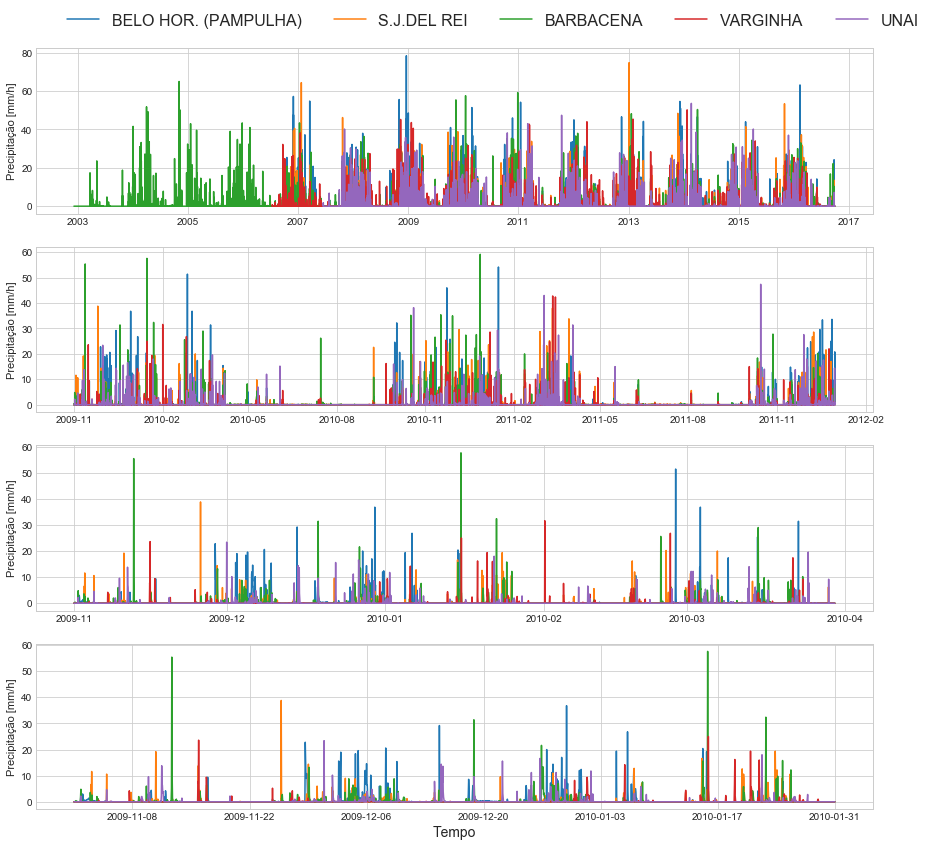

In [39]:
wsToShow = [u'BELO HOR. (PAMPULHA)',u'S.J.DEL REI',u'BARBACENA',u'VARGINHA',u'UNAI']

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(15,14))
for i, p in enumerate(p):
    for k in range(len(wsToShow)):
        ax[i].plot(p,dfaux.loc[p,wsToShow[k]])
        
ax[0].legend(wsToShow, fontsize=16,
              loc='upper left',bbox_to_anchor=(0.02,1.3), ncol=len(wsToShow))
for i in range(len(ax)): ax[i].set_ylabel(u'Precipitação [mm/h]', fontsize=11)
ax[3].set_xlabel('Tempo', fontsize=14);

<p>Pode se notar que as chuvas estão localidas no verão entre os meses de Dezembro a Março (primeiro gráfico). Além disto pode notar que existem nestes cidades algumas instâncias com chuvas acima de 50mm/h o que é bastante alto, se comparamos que o liminar para classificar chuva extrema é 50mm por 24 horas.</p>

In [40]:
wsToShow = 'BARBACENA'
selectedLagPoints =  range(1,12,3)
maxLagDays= 1

In [41]:
from pandas.plotting import autocorrelation_plot, lag_plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [42]:
originalSignal = dfaux[wsToShow]

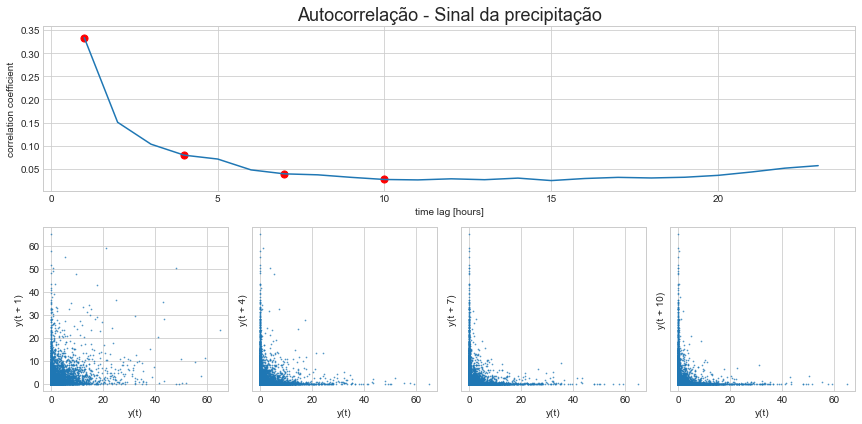

In [43]:
plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2, len(selectedLagPoints))
axTopRow = plt.subplot(gs[0, :])
axBottomRow = []
for i in range(len(selectedLagPoints)):
    axBottomRow.append(plt.subplot(gs[1, i]))
    
allTimeLags = np.arange(1,maxLagDays*24)
autoCorr = [originalSignal.autocorr(lag=dt) for dt in allTimeLags]
axTopRow.plot(allTimeLags,autoCorr); 
axTopRow.set_title(u'Autocorrelação - Sinal da precipitação', fontsize=18);
axTopRow.set_xlabel('time lag [hours]'); axTopRow.set_ylabel('correlation coefficient')
selectedAutoCorr = [originalSignal.autocorr(lag=dt) for dt in selectedLagPoints]
axTopRow.scatter(x=selectedLagPoints, y=selectedAutoCorr, s=50, c='r')

for i in range(len(selectedLagPoints)):
    lag_plot(originalSignal, lag=selectedLagPoints[i], s=0.5, alpha=0.7, ax=axBottomRow[i])    
    if i >= 1:
        axBottomRow[i].set_yticks([],[])
plt.tight_layout()

In [49]:
dfauxext = dfext
dfauxext = dfauxext[(dfauxext['prov']=='MG')]
dfauxext.head(3)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust,peid
785083,312,BARBACENA,1169.0,-21.228373,-43.767703,A502,Barbacena,MG,2003-03-21 19:00:00,2003-03-21 00:00:00,...,19.2,17.8,16.8,94.0,95.0,68.0,0.0,0.0,0.0,NaN
785084,312,BARBACENA,1169.0,-21.228373,-43.767703,A502,Barbacena,MG,2003-03-21 20:00:00,2003-03-21 00:00:00,...,18.0,17.7,16.7,94.0,95.0,93.0,0.0,0.0,0.0,NaN
785085,312,BARBACENA,1169.0,-21.228373,-43.767703,A502,Barbacena,MG,2003-03-21 21:00:00,2003-03-21 00:00:00,...,19.1,18.7,17.6,87.0,94.0,87.0,0.0,0.0,0.0,NaN


In [50]:
dfauxext = dfauxext.pivot(index ='mdct',columns='wsnm',values='prcp')

In [51]:
dfauxext.head(5)

wsnm,AIMORES,ALMENARA,ARAXÁ,BARBACENA,BELO HOR. (PAMPULHA),BELO HORIZONTE - CERCADINHO,BURITIS,CALDAS,CAMPINA VERDE,CAPELINHA,...,SÃO ROMÃO,SÃO SEBASTIAO DO PARAÍSO,TEÓFILO OTONI,TIMÓTEO,TRÊS MARIAS,UBERLÂNDIA,UNAI,VARGINHA,VIÇOSA,ÁGUAS VERMELHAS
mdct,,,,,,,,,,,,,,,,,,,,,
2002-12-20 01:00:00,NaN,NaN,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-20 02:00:00,NaN,NaN,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-20 03:00:00,NaN,NaN,16.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-20 04:00:00,NaN,NaN,30.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-20 05:00:00,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
wsToShow = 'BELO HOR. (PAMPULHA)'
originalSignal = dfaux[wsToShow]

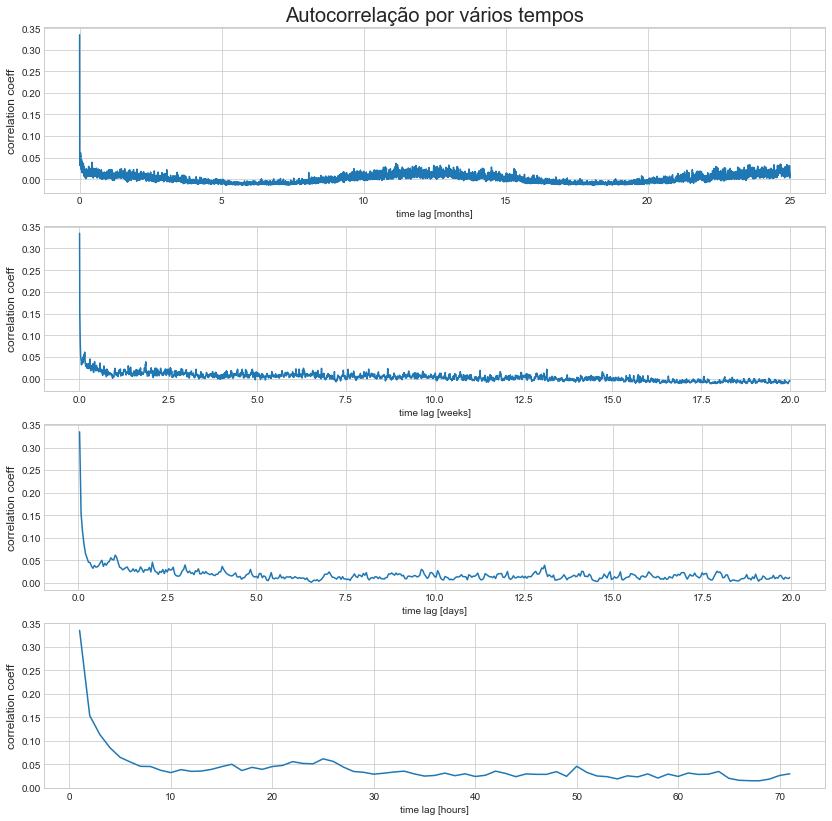

In [60]:
#%% zoom in and out on the autocorr plot
fig, ax = plt.subplots(nrows=4,ncols=1, figsize=(14,14))

timeLags = np.arange(1,25*24*30)
autoCorr = [originalSignal.autocorr(lag=dt) for dt in timeLags]
ax[0].plot(1.0/(24*30)*timeLags, autoCorr); ax[0].set_title(u'Autocorrelação por vários tempos', fontsize=20);
ax[0].set_xlabel('time lag [months]'); ax[0].set_ylabel('correlation coeff', fontsize=12);

timeLags = np.arange(1,20*24*7)
autoCorr = [originalSignal.autocorr(lag=dt) for dt in timeLags]
ax[1].plot(1.0/(24*7)*timeLags, autoCorr);
ax[1].set_xlabel('time lag [weeks]'); ax[1].set_ylabel('correlation coeff', fontsize=12);

timeLags = np.arange(1,20*24)
autoCorr = [originalSignal.autocorr(lag=dt) for dt in timeLags]
ax[2].plot(1.0/24*timeLags, autoCorr);
ax[2].set_xlabel('time lag [days]'); ax[2].set_ylabel('correlation coeff', fontsize=12);

timeLags = np.arange(1,3*24)
autoCorr = [originalSignal.autocorr(lag=dt) for dt in timeLags]
ax[3].plot(timeLags, autoCorr);
ax[3].set_xlabel('time lag [hours]'); ax[3].set_ylabel('correlation coeff', fontsize=12);

In [52]:
wsToShow = 'BELO HOR. (PAMPULHA)'
selectedLagPoints =  range(1,24,3)
maxLagDays= 1
originalSignal = dfauxext[wsToShow]

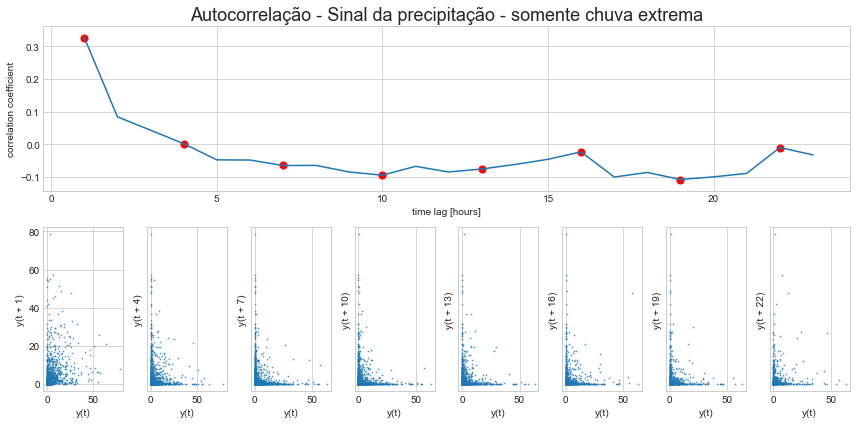

In [53]:
plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2, len(selectedLagPoints))
axTopRow = plt.subplot(gs[0, :])
axBottomRow = []
for i in range(len(selectedLagPoints)):
    axBottomRow.append(plt.subplot(gs[1, i]))
    
allTimeLags = np.arange(1,maxLagDays*24)
autoCorr = [originalSignal.autocorr(lag=dt) for dt in allTimeLags]
axTopRow.plot(allTimeLags,autoCorr); 
axTopRow.set_title(u'Autocorrelação - Sinal da precipitação - somente chuva extrema', fontsize=18);
axTopRow.set_xlabel('time lag [hours]'); axTopRow.set_ylabel('correlation coefficient')
selectedAutoCorr = [originalSignal.autocorr(lag=dt) for dt in selectedLagPoints]
axTopRow.scatter(x=selectedLagPoints, y=selectedAutoCorr, s=50, c='r')

for i in range(len(selectedLagPoints)):
    lag_plot(originalSignal, lag=selectedLagPoints[i], s=0.5, alpha=0.7, ax=axBottomRow[i])    
    if i >= 1:
        axBottomRow[i].set_yticks([],[])
plt.tight_layout()